In [110]:
import numpy as np
import pandas as pd
import os
import datetime
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,  cross_val_score
import xgboost as xgb
import seaborn as sns
import time
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from catboost import CatBoostRegressor
%matplotlib inline   

In [111]:
def missing_value_of_data(data):
    ''' Выявляет пропуски'''
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

def unique_values_in_column(data,feature):
    ''' Выводит уникальные значения'''
    unique_val=pd.Series(data.loc[:,feature].unique())
    return pd.concat([unique_val],axis=1,keys=['Unique Values'])

def my_hist(x, figsize=(14, 3)):
    ''' Гисторграмма + медиана/мода/средн.арихфм. '''
    target_mean = round(x.mean(), 2)
    target_median = x.median()
    target_mode = x.mode()[0]

    plt.figure(figsize=figsize)

    sns.distplot(x, bins=min(50,len(set(x.unique()))))

    plt.axvline(x=[target_mean], label='mean',
                linestyle=':', color="red", linewidth=4)
    plt.axvline(x=[target_median], label='median',
                linestyle='--', color="green", linewidth=4)
    plt.axvline(x=[target_mode], label='mode',
                linestyle='-.', color="brown", linewidth=4)

    plt.title(f'Distribution of {x.name}')
    plt.xlabel(x.name)
    plt.ylabel('Frequency')
    plt.show()

def my_boxplot(x,y,ampX=1,ampY=1, f_e=(14, 3)):
    """ Боксплот для оценки связи параметров """
    plt.figure(figsize = f_e)
    x_s = (round(x/ampX,0)*ampX).astype(np.int32)
    y_s = (round(y/ampY,0)*ampY).astype(np.int32)    
    
    sns.boxplot(x_s, y_s)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.title(f'Distribution of {x.name} by {y.name}')
    plt.show()
    
def plot_feature_importances(importances, X):

    indices = np.argsort(importances)[::-1]
    """ для оценки влияния параметров на модель """
    plt.figure(figsize=(20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
            color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()

In [112]:
TRAIN_DATASET_PATH = 'C:/Users/1/Downloads/reppm/train.csv'
TEST_DATASET_PATH = 'C:/Users/1/Downloads/reppm/test.csv'

In [115]:
df = pd.read_csv(TRAIN_DATASET_PATH)
X_final = pd.read_csv(TEST_DATASET_PATH)

In [116]:
X = df.drop('Price', axis=1)
y = df[['Price']]

In [117]:
MAX_Rooms = 5
MULT10_Square_MAX_treshhold = 15 # минимальная допустимая Square
DIV10_Square_MIN_treshhold = 280 # максимальная допустимая Square

MIN_KitchenSquare = 2 # минимальная допустимая KitchenSquare
SUSP_KitchenSquare = 5 # KitchenSquare ниже этой границы - подозрительная - к ней применю дополнительные проверки
MAX_KitchenSquare = 32 # максимальная допустимая KitchenSquare

MIN_LifeSquare = 10 # минимальная допустимая LifeSquare
MAX_LifeSquare = 240# максимальная допустимая LifeSquare

In [119]:
df["SqmPrice"] = df["Price"]/df["Square"]

In [120]:
condition1 = df.Square<MULT10_Square_MAX_treshhold
features_analysed = ['DistrictId','Rooms','Square','LifeSquare','KitchenSquare','Price','SqmPrice']
df[features_analysed][condition1].sample(4)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Price,SqmPrice
8572,6,1.0,2.596351,4.604943,1.0,137597.601458,52996.529388
328,27,3.0,4.390331,5.610772,1.0,161379.067034,36757.837204
9286,81,3.0,13.784865,15.988889,7.0,78388.806186,5686.585073
4800,38,1.0,4.502784,4.618547,1.0,483283.488083,107329.937099


In [121]:
condition2 = df.Square>DIV10_Square_MIN_treshhold
df[features_analysed][condition2]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Price,SqmPrice
726,9,2.0,604.705972,NaN,1.0,187717.242538,310.427301
7010,102,1.0,409.425181,410.639749,10.0,90470.430830,220.969386
9229,30,2.0,641.065193,638.163193,10.0,133529.681562,208.293451


In [122]:
MAX_HouseFloor = 40
MAX_Floor = 40

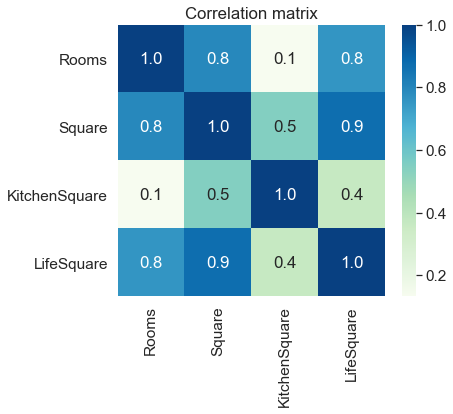

In [123]:
condition1 = ((df.Rooms > 0) & (df.Rooms<6))
condition2 = ((df.Square > 15) & (df.Square<280))
condition3 = ((df.KitchenSquare > 2) & (df.KitchenSquare<32))
condition4 = ((df.LifeSquare > 10) & (df.LifeSquare<240))

suspected_corr = df[['Rooms','Square','KitchenSquare','LifeSquare']][condition1&condition2&condition3&condition4]

corr = suspected_corr.corr()
plt.figure(figsize = (6, 5))
sns.set(font_scale=1.4)
sns.heatmap(suspected_corr.corr(), annot=True, fmt='.1f', cmap='GnBu')
plt.title('Correlation matrix')
plt.show()

In [124]:
class WorkFllow:

    def __init__(self):
        self.regression_Sq_Ktchn = None
        self.regression_Sq_Life = None
        self.regression_Sq_Rooms = None
        self.DistrictId_counts = None
        self.Aver_HC1_by_D = None
        self.Sqm_P_by_D = None
        self.Rooms_in_D = None
        self.Sqm_P_by_D_STD = None
        self.binary_to_numbers = {'A': 0, 'B': 1}  # Binary features



    def step_1_transform_before_regressions(self, X):

        # Switch LS & S
        condition = ((X.LifeSquare > X.Square) & (X.LifeSquare/10 <= DIV10_Square_MIN_treshhold))
        
        X['Square_outlier'] = 0
        X['LifeSquare_outlier'] = 0
        X.loc[condition,'Square_outlier'] = 1
        X.loc[condition,'LifeSquare_outlier'] = 1
        
        X.loc[condition, ['LifeSquare', 'Square']
              ] = X.loc[condition, ['Square', 'LifeSquare']].values

        # KS Minor adjust
        condition = ((X.KitchenSquare > X.Square) & (
            X.KitchenSquare <= MAX_KitchenSquare*10))
        
        X['KitchenSquare_outlier'] = 0
        X.loc[condition,'KitchenSquare_outlier'] = 1
        
        X.loc[condition, "KitchenSquare"] = X.loc[condition, "KitchenSquare"]/10
        condition = ((X.KitchenSquare > X.Square) & (
            X.KitchenSquare > MAX_KitchenSquare*10))
        
        X.loc[condition, 'KitchenSquare_outlier'] = 1
        X.loc[condition, "KitchenSquare"] = 0

        # S adjust where it is 10folds bigger
        condition = (X.Square > DIV10_Square_MIN_treshhold) & (
            X.LifeSquare < MAX_LifeSquare)
        
        
        X.loc[condition,'LifeSquare_outlier'] = 1
        X.loc[condition, "Square"] = X.loc[condition, "Square"]/10

        # S & LS adjust where it is 10folds bigger
        condition = ((X.LifeSquare > X.Square) & (X.LifeSquare/10 > DIV10_Square_MIN_treshhold))
        X.loc[condition,'LifeSquare_outlier'] = 1
        X.loc[condition, "LifeSquare"] = X.loc[condition, "LifeSquare"]/100
        
        
        # AGAIN Switch LS & S
        condition = ((X.LifeSquare > X.Square) & (X.LifeSquare/10 <= DIV10_Square_MIN_treshhold))
        
        X.loc[condition,'Square_outlier'] = 1
        X.loc[condition,'LifeSquare_outlier'] = 1
        
        X.loc[condition, ['LifeSquare', 'Square']
              ] = X.loc[condition, ['Square', 'LifeSquare']].values

     
        # S & LS adjust where it is 10folds bigger
        condition = (X.Square > DIV10_Square_MIN_treshhold)
        
        X.loc[condition,'Square_outlier'] = 1
        X.loc[condition,'LifeSquare_outlier'] = 1
        X.loc[condition, "Square"] = X.loc[condition, "Square"]/10
        
        condition = (X.LifeSquare > MAX_LifeSquare)
        X.loc[condition, "LifeSquare"] = X.loc[condition, "LifeSquare"]/10

        condition = (X.Square < MULT10_Square_MAX_treshhold)
        X.loc[condition, "Square"] = X.loc[condition, "Square"]*10
        
        condition = (X.LifeSquare < MIN_LifeSquare)
        X.loc[condition, "LifeSquare"] = X.loc[condition, "LifeSquare"]*10

        X.loc[condition,'Square_outlier'] = 1
        X.loc[condition,'LifeSquare_outlier'] = 1
        
        # KS rough adjust - reset to 0 all suspicious KitchenSquare to fill it later with Linear regression
        condition = (X.KitchenSquare > MAX_KitchenSquare) & (
            X.KitchenSquare > X.Square/2)
        X.loc[condition,'KitchenSquare_outlier'] = 1
        X.loc[condition, "KitchenSquare"] = 0

        condition = (X.KitchenSquare < X.Square/18)
        X.loc[condition, "KitchenSquare"] = 0

        condition = ((X.KitchenSquare < SUSP_KitchenSquare) & (X.KitchenSquare > 1) & (
            (X.KitchenSquare == X.Rooms) | (X.KitchenSquare == X.Floor)))
        X.loc[condition, "KitchenSquare"] = 0

        condition = (X.KitchenSquare < MIN_KitchenSquare)
        X.loc[condition, "KitchenSquare"] = 0

        # HouseFloor / Floor
        
        # Switch HF & F
        condition = (X.Floor > X.HouseFloor)
        X.loc[condition,'HF_F_outlier'] = 1
        X.loc[condition, ['HouseFloor', 'Floor']
              ] = X.loc[condition, ['HouseFloor', 'Floor']].values

        # Remove non existing floors
        
        condition = (X['HouseFloor'] > MAX_HouseFloor)
        X['HF_F_outlier'] = 0
        X.loc[condition,'HF_F_outlier'] = 1
        X.loc[condition, 'HouseFloor'] = 0
        
        condition = (X['Floor'] > MAX_Floor)
        X.loc[condition,'HF_F_outlier'] = 1
        X.loc[condition, 'Floor'] = 0

        condition = (X['HouseFloor'] == 0)
        X.loc[condition,'HF_F_outlier'] = 1
        X.loc[condition, 'HouseFloor'] = 1

        condition = (X['Floor'] == 0)
        X.loc[condition,'HF_F_outlier'] = 1
        X.loc[condition, 'Floor'] = X.loc[condition, 'HouseFloor']//2+1

        # HouseYear
        current_year = now = datetime.datetime.now().year
        X['HouseYear_outlier'] = 0
        condition = X['HouseYear'] > current_year
        X.loc[condition,'HouseYear_outlier'] = 1
        X.loc[condition, 'HouseYear'] = round(X['HouseYear'].median(), 0)

        
        # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        gc.collect()
        return X
    
    
    def step_2_fit_regressions(self, X_train, X_test):

        Both = pd.concat([X_train, X_test,], axis=0)
        # KS adjust
        # потому что все ненормальные значения уже сброшены до 0
        condition = (Both.KitchenSquare > 0)
        
        # Потому что не хочу предсказывать одни значения на основании предсказанных / других фич - это может сильно увеличить амплитуду возможной ошибки.
        Xc = Both[condition].drop(['KitchenSquare', 'LifeSquare', 'Rooms','Healthcare_1'], axis=1)
        yc = Both[condition].KitchenSquare
        
        self.regression_Sq_Ktchn = CatBoostRegressor(
            iterations=420,
            depth=7,
            learning_rate=.15,
            loss_function='RMSE',
            eval_metric="R2",
            silent=True,
        )
        
                
        self.regression_Sq_Ktchn.fit(Xc, yc)
        c_validator = cross_val_score(self.regression_Sq_Ktchn, Xc, yc, cv=5, scoring='r2')
        print(
            'KitchenSquare R2: {:.4f} +- {:.4f}'.format(c_validator.mean(), c_validator.std()))
        
      
        # LS adjust
        condition = (Both.LifeSquare.isna() == False)
        # Потому что не хочу предсказывать одни значения на основании предсказанных / других фич - это может сильно увеличить амплитуду возможной ошибки.
        Xc = Both[condition].drop(
            ['KitchenSquare', 'LifeSquare', 'Rooms','Healthcare_1'], axis=1)
        yc = Both[condition].LifeSquare

        self.regression_Sq_Life = CatBoostRegressor(
            iterations=280,
            depth=7,
            learning_rate=.05,
            loss_function='RMSE',
            eval_metric="R2",
            silent=True,
        )
        
        self.regression_Sq_Life.fit(Xc, yc)
        c_validator=cross_val_score(self.regression_Sq_Life, Xc, yc, cv=5, scoring='r2')
        print(
            'LifeSquare R2: {:.4f} +- {:.4f}'.format(c_validator.mean(), c_validator.std()))

        # Rooms adjust
        condition = (Both['Rooms'] >= 1) & (Both['Rooms'] <= MAX_Rooms)
        
        # Потому что не хочу предсказывать одни значения на основании предсказанных / других фич - это может сильно увеличить амплитуду возможной ошибки.
        Xc = Both[condition].drop(
            ['KitchenSquare', 'LifeSquare', 'Rooms','Healthcare_1'], axis=1)
        
        yc = Both[condition].Rooms
        
        self.regression_Sq_Rooms=CatBoostRegressor(
            iterations=460,
            depth=7,
            learning_rate=.08,
            loss_function='RMSE',
            eval_metric="R2",
            silent=True,
        )
        
        self.regression_Sq_Rooms.fit(Xc, yc)

        c_validator=cross_val_score(self.regression_Sq_Rooms, Xc, yc, cv=5, scoring='r2')
        print(
            'Rooms R2: {:.4f} +- {:.4f}'.format(c_validator.mean(), c_validator.std()))
        
       
        
        del Both

        
    def step_3_apply_regressions(self, X):

        # KS regression adjust
        condition = (X.KitchenSquare == 0)
        
        Xc = X[condition].drop(['KitchenSquare', 'LifeSquare', 'Rooms','Healthcare_1'], axis=1)
        
        X.loc[condition, 'KitchenSquare'] = self.regression_Sq_Ktchn.predict(Xc)

        # Rooms regression adjust
        condition = (X['Rooms'] < 1) | (X['Rooms'] > MAX_Rooms)
        
        Xc = X[condition].drop(['KitchenSquare', 'LifeSquare', 'Rooms','Healthcare_1'], axis=1)
            
        X['Rooms_outlier'] = 0
        
        X.loc[condition,'Rooms_outlier'] = 1
        
        X.loc[condition, 'Rooms'] = self.regression_Sq_Rooms.predict(Xc)
        X.Rooms = (round(X.Rooms, 0)).astype(np.int16)

        
 
        # After KitchenSquare is adjusted -> LifeSquare may be adjusted as well
        # Mark anomal items as NaN
        condition = (X.LifeSquare < X.Square/3) # можно играть со значением
        X.loc[condition, "LifeSquare"] = np.nan
       
        condition = (X.LifeSquare < X.KitchenSquare*2)
        X.loc[condition, "LifeSquare"] = np.nan
        
        condition = (X.LifeSquare + X.KitchenSquare > X.Square) & (X.LifeSquare.isna() == False)
        X.loc[condition, "LifeSquare"] = np.nan

        # LS regression adjust
        condition = (X.LifeSquare.isna() == True)
        
        Xc = X[condition].drop(['KitchenSquare', 'LifeSquare', 'Rooms','Healthcare_1'], axis=1)
                
        
        X.loc[condition,'LifeSquare_outlier'] = 1
        X.loc[condition, 'LifeSquare'] = self.regression_Sq_Life.predict(Xc)
        
  
        gc.collect()
        return X

    
    def step_4_fit_features(self, X,X_final, y):
        
        All = pd.concat([X, y], axis=1)
        Both = pd.concat([X, X_final,], axis=0)
        
        # DistrictID
        # Определяю частотность с учетом частотности в тестовом сете!
        district = Both['DistrictId'].value_counts()
#         district = district[district >= 0]  # Можно играть со значением
        self.DistrictId_counts = dict(district)
        
        # Определяю среднюю по району Healthcare_1 с учетом тестового сета. 
        #av_HC_1 (median - worse)
        condition = (Both.Healthcare_1.isna() == False)
        self.Aver_HC1_by_D = Both[condition].groupby('DistrictId', as_index=False).agg(
            {'Healthcare_1': 'mean'}).rename(columns={'Healthcare_1': 'Aver_HC1_by_D'})
        
        # Total_Rooms_in_Distr
        self.Rooms_in_D = Both[condition].groupby('DistrictId', as_index=False).agg(
            {'Rooms': 'sum'}).rename(columns={'Rooms': 'Total_Rooms_in_Distr'})
                
        # av_SQMprice
        # а вот показатели завязанные на предсказываемую фичу - рассчитываю тольо на тренировочном сете.
        condition = (All.Square > MULT10_Square_MAX_treshhold) & (All.Square < DIV10_Square_MIN_treshhold)

        All["SqmPrice"] = All["Price"]/All["Square"]
 
        self.Sqm_P_by_D = All[condition].groupby('DistrictId', as_index=False).agg(
            {'SqmPrice': 'mean'}).rename(columns={'SqmPrice': 'Av_SqmPrice_by_Distr'})


    
        self.Sqm_P_by_D_STD = All[condition].groupby('DistrictId', as_index=False).agg(
            {'SqmPrice': 'std'}).rename(columns={'SqmPrice': 'Price_STD'})
    
    
    
        
        del All
        del Both
    
    def step_5_do_features(self, X):
                
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)


        # Age
        X["HouseAge"] = np.int32(2021 - X["HouseYear"])
        X.drop("HouseYear", axis=1, inplace=True)


        # av_SQMprice
        X = X.merge(self.Sqm_P_by_D, on=["DistrictId"], how='left')
        X.Av_SqmPrice_by_Distr.fillna(
            self.Sqm_P_by_D.Av_SqmPrice_by_Distr.median(), inplace=True)
        
        
        # av_SQMprice_STD
        X = X.merge(self.Sqm_P_by_D_STD, on=["DistrictId"], how='left')
        X.Av_SqmPrice_by_Distr.fillna(
            self.Sqm_P_by_D_STD.Price_STD.mean(), inplace=True)

 
        # Aver_HC1_by_D
        X = X.merge(self.Aver_HC1_by_D, on=["DistrictId"], how='left')
        
        # Healthcare_1 adjust with mean value for region
        condition = (X.Healthcare_1.isna() == True)
        
        X['Healthcare_1_outlier'] = 0
        X.loc[condition,'Healthcare_1_outlier'] = 1
        X.loc[condition, 'Healthcare_1'] = X.Aver_HC1_by_D

        X.Healthcare_1.fillna(0, inplace=True)
        X.Aver_HC1_by_D.fillna(0, inplace=True)
        

        # Total_Rooms_in_Distr_count * Total_Rooms_in_Distr
        X = X.merge(self.Rooms_in_D, on=["DistrictId"], how='left')

        X['DistrictId_x_Rooms_count'] = X['Total_Rooms_in_Distr'] * X['DistrictId_count']


        # F_Probable_Price
        
        X['F_Probable_Price'] = X.Square * X.Av_SqmPrice_by_Distr
        
 
        gc.collect()
        return X

In [125]:
imputer = WorkFllow()

# 1. Первый этап коррекций, ДО фита, чтобы линейные регресси были качественными
X = imputer.step_1_transform_before_regressions(X)
X_final = imputer.step_1_transform_before_regressions(X_final)
print ('1-ok')

# 2. Фит регрессий - расчет значений, которые потом будут применены для коррекции пропусков факторов как в X так и в X_final
imputer.step_2_fit_regressions(X,X_final)
print ('2-ok')

# 3. Заполнение пропусков регрессиями
X = imputer.step_3_apply_regressions(X)
X_final = imputer.step_3_apply_regressions(X_final)
print ('3-ok')

# 4. Формирование массивов для генерации кодированных ценой фич
imputer.step_4_fit_features(X,X_final,y)
print ('4-ok')

# 5.Генерация фич
X = imputer.step_5_do_features(X)
X_final = imputer.step_5_do_features(X_final)
print ('5-ok')

1-ok
KitchenSquare R2: 0.6749 +- 0.0173
LifeSquare R2: 0.7642 +- 0.0198
Rooms R2: 0.8588 +- 0.0057
2-ok
3-ok
4-ok
5-ok


In [126]:
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

In [127]:
remain_features = ['DistrictId_count', 'Av_SqmPrice_by_Distr',
       'Total_Rooms_in_Distr', 'DistrictId_x_Rooms_count', 'Ecology_3',
       'Square', 'Rooms', 'KitchenSquare', 'Floor', 'HouseFloor', 'Ecology_1',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'HouseAge', 'F_Probable_Price', 'Price_STD']

X = X[remain_features]

X_final = X_final[remain_features]

In [128]:
%%time
parameters = {'silent': True, 
              'learning_rate': 0.023, 
              'iterations': 1005, 
              'eval_metric': 'R2', 
              'depth': 10,
              'allow_writing_files': False}


model_CBR = CatBoostRegressor(**parameters)

model_CBR.fit(X, y)

cv_score = cross_val_score(model_CBR, X, y,
                           scoring='r2',
                           cv=KFold(n_splits=5,
                                    shuffle=True,
                                    random_state=2021,
                                    ))
print('R2: {:.4f} +- {:.4f}'.format(cv_score.mean(), cv_score.std()))

R2: 0.7706 +- 0.0098
Wall time: 4min 43s


In [134]:
y_pred_final = model_CBR.predict(X_final)
preds_final['Price'] = y_pred_final

preds_final.to_csv('C:/Users/1/Downloads/reppm/rf_submit.csv', index=False)

preds_final.head()

,Id,Price
0,4567,166770.825657
1,5925,120397.768158
2,960,140597.687483
3,3848,100973.287760
4,746,179755.708820


In [132]:
preds_final.shape

(5000, 2)

In [133]:
X_final.shape, X.shape

((5000, 20), (10000, 20))